In [1]:
import numpy as np
import pandas as pd
np.random.seed(123)

# viz
import matplotlib.pyplot as plt

# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 1000)

## Sample Prep

In [2]:
samples = pd.read_csv('../data/TCGA/rna-seq_pan/meta/gdc_sample_sheet.2019-12-12.tsv', sep="\t")
# get file type
samples['data'] = [val[1] for i,val in samples['File Name'].str.split(".").items()]
samples.head()

,File ID,File Name,Data Category,Data Type,Project ID,Case ID,Sample ID,Sample Type,data
0,754774dd-77e1-4cf5-b9b5-3afad9f41410,999edb9e-8a45-4115-84d5-fca75dcfa639.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-BRCA,TCGA-E2-A1IG,TCGA-E2-A1IG-01A,Primary Tumor,FPKM
1,8bf102b9-baf7-4749-bcd0-eca25f600722,23393a6a-bfbc-4dec-9ab5-e78a487a095f.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-BRCA,TCGA-EW-A1J5,TCGA-EW-A1J5-01A,Primary Tumor,FPKM
2,5bf7609e-68cb-4ddb-8f05-ee1d4f92cf9b,4a9bb3fd-4e75-4585-82f7-7254889b9838.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-BRCA,TCGA-AR-A1AU,TCGA-AR-A1AU-01A,Primary Tumor,FPKM
3,10a40ceb-080c-4758-97f9-1a262e2639ed,9858d286-1b96-4414-bd09-d73dc6f1c79e.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LGG,TCGA-DB-A64R,TCGA-DB-A64R-01A,Primary Tumor,FPKM
4,2600ef39-0bdf-4e10-9fdf-e3dbed7b5383,f7182de7-067e-467b-af88-790ad3e63eec.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LGG,TCGA-P5-A77X,TCGA-P5-A77X-01A,Primary Tumor,FPKM


Samples with RNAseq adjacent normal tissue

In [3]:
samples[samples['Sample Type']=='Solid Tissue Normal']['data'].value_counts()

FPKM    636
Name: data, dtype: int64

In [4]:
samples['project'] = [val[1] for i,val in samples['Project ID'].str.split("-").items()]
samples['project'].value_counts()

BRCA    1206
LUAD     588
UCEC     567
KIRC     554
LUSC     543
LGG      524
PRAD     517
COAD     506
THCA     505
SKCM     469
BLCA     431
LIHC     421
STAD     402
OV       379
KIRP     308
CESC     306
ESCA     171
PAAD     171
GBM      166
TGCT     150
PCPG     133
LAML     123
KICH      81
ACC       75
CHOL      41
SARC      10
DLBC       9
READ       7
MESO       1
Name: project, dtype: int64

In [5]:
# all cases with adjacent normal tissue
cases = samples[samples['Sample Type']=='Solid Tissue Normal']['Case ID']

In [6]:
# disparity in cases
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') 
        & (samples['data']=='FPKM') & (samples['project']=='BRCA')]['Case ID'].nunique()
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') 
        & (samples['data']=='FPKM') & (samples['project']=='BRCA')]['Case ID'].nunique()

111

112

In [7]:
# divide, join, subset
case_tumor = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') & 
                     (samples['data']=='FPKM') & (samples['project']=='BRCA')]
case_norm = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') & 
                    (samples['data']=='FPKM') & (samples['project']=='BRCA')]
cases = case_norm[case_norm['Case ID'].isin(case_tumor['Case ID'])]['Case ID']
cases.shape

(111,)

In [8]:
case_tumor = case_tumor[case_tumor['Case ID'].isin(cases)]
case_norm = case_norm[case_norm['Case ID'].isin(cases)]
cases = pd.concat([case_tumor, case_norm])

In [9]:
case_tumor.shape
case_norm.shape
cases.shape

(116, 10)

(111, 10)

(227, 10)

## Dataset Prep

In [10]:
from sklearn.model_selection import train_test_split

target = 'Sample Type'
cases[target] = cases[target].astype('category')

train, test = train_test_split(cases)
train[target].value_counts()
test[target].value_counts()

Primary Tumor          90
Solid Tissue Normal    80
Name: Sample Type, dtype: int64

Solid Tissue Normal    31
Primary Tumor          26
Name: Sample Type, dtype: int64

In [11]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
torch.manual_seed(123)

from trainer import fit
import visualization as vis
import numpy as np
cuda = torch.cuda.is_available()
print("Cuda is available: {}".format(cuda))

classes = train[target].cat.categories.values


Cuda is available: True


In [12]:
from tcga_datasets import TCGA, SiameseTCGA
root_dir = "../data/TCGA/rna-seq_pan/"
batch_size = 1

train_dataset = TCGA(root_dir, samples=train, train=True, target=target)
test_dataset = TCGA(root_dir, samples=test, train=False, target=target)

kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {'num_workers': 10}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

## Siamese Network

In [13]:
# Step 1 set up dataloader
root_dir = "../data/TCGA"
siamese_train_dataset = SiameseTCGA(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseTCGA(test_dataset)
batch_size = 8
kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from tcga_networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss
from metrics import AccumulatedAccuracyMetric

# Step 2
embedding_net = EmbeddingNet()
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10
# print training metrics every log_interval * batch_size
log_interval = 30

SiameseNet(
  (embedding_net): EmbeddingNet(
    (fc): Sequential(
      (linear1): Linear(in_features=60483, out_features=2000, bias=True)
      (relu1): PReLU(num_parameters=1)
      (linear2): Linear(in_features=2000, out_features=500, bias=True)
      (relu2): PReLU(num_parameters=1)
      (linear3): Linear(in_features=500, out_features=250, bias=True)
      (relu3): PReLU(num_parameters=1)
      (linear4): Linear(in_features=250, out_features=100, bias=True)
      (relu4): PReLU(num_parameters=1)
      (linear5): Linear(in_features=100, out_features=50, bias=True)
      (relu5): PReLU(num_parameters=1)
      (linear6): Linear(in_features=50, out_features=10, bias=True)
      (relu6): PReLU(num_parameters=1)
      (linear7): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [14]:
train_loss, val_loss = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, 
    n_epochs, cuda, log_interval)

Train: [0/170 (0%)]	Loss: 0.268963
Epoch: 1/10. Train set: Average loss: 109.3384
Epoch: 1/10. Validation set: Average loss: 19.4182
Train: [0/170 (0%)]	Loss: 309.796631
Epoch: 2/10. Train set: Average loss: 128.6826
Epoch: 2/10. Validation set: Average loss: 146.4794
Train: [0/170 (0%)]	Loss: 120.472649
Epoch: 3/10. Train set: Average loss: 220.2393
Epoch: 3/10. Validation set: Average loss: 7.1959
Train: [0/170 (0%)]	Loss: 1.989862
Epoch: 4/10. Train set: Average loss: 13.7897
Epoch: 4/10. Validation set: Average loss: 0.8082
Train: [0/170 (0%)]	Loss: 3.589590
Epoch: 5/10. Train set: Average loss: 3.9411
Epoch: 5/10. Validation set: Average loss: 5.1269
Train: [0/170 (0%)]	Loss: 0.450236
Epoch: 6/10. Train set: Average loss: 8.6736
Epoch: 6/10. Validation set: Average loss: 0.8676
Train: [0/170 (0%)]	Loss: 0.245182
Epoch: 7/10. Train set: Average loss: 1.4281
Epoch: 7/10. Validation set: Average loss: 0.2053
Train: [0/170 (0%)]	Loss: 0.009832
Epoch: 8/10. Train set: Average loss: 0.6

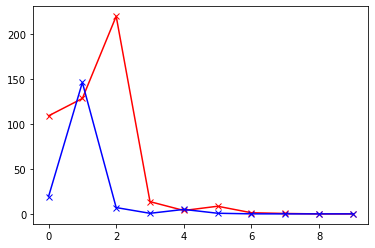

In [15]:
plt.plot(range(0, n_epochs), train_loss, 'rx-')
plt.plot(range(0, n_epochs), val_loss, 'bx-')

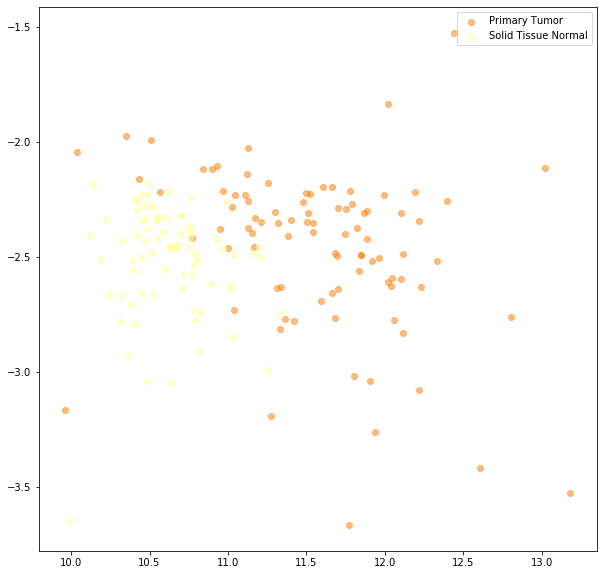

In [16]:
train_embeddings_cl, train_labels_cl = vis.extract_embeddings(train_loader, model)
vis.plot_embeddings(train_embeddings_cl, train_labels_cl, classes)

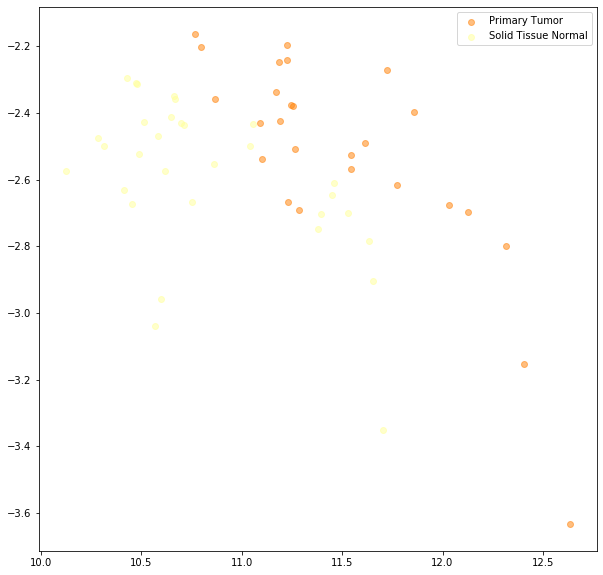

In [17]:
val_embeddings_baseline, val_labels_baseline = vis.extract_embeddings(test_loader, model)
vis.plot_embeddings(val_embeddings_baseline, val_labels_baseline, classes)

## Activation Maximization

In [18]:
# need to record activations at final layer
# then optimize random

In [19]:
import copy
from captum.attr import LayerActivation

In [20]:
tmp_model = copy.deepcopy(model)

In [21]:
tmp_model

SiameseNet(
  (embedding_net): EmbeddingNet(
    (fc): Sequential(
      (linear1): Linear(in_features=60483, out_features=2000, bias=True)
      (relu1): PReLU(num_parameters=1)
      (linear2): Linear(in_features=2000, out_features=500, bias=True)
      (relu2): PReLU(num_parameters=1)
      (linear3): Linear(in_features=500, out_features=250, bias=True)
      (relu3): PReLU(num_parameters=1)
      (linear4): Linear(in_features=250, out_features=100, bias=True)
      (relu4): PReLU(num_parameters=1)
      (linear5): Linear(in_features=100, out_features=50, bias=True)
      (relu5): PReLU(num_parameters=1)
      (linear6): Linear(in_features=50, out_features=10, bias=True)
      (relu6): PReLU(num_parameters=1)
      (linear7): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [22]:
torch.cuda.current_device()

0

#### Input layer activation

In [ ]:
data1, data2, label = tuple(siamese_test_dataset.test_pairs[-1])
data1 = Variable(siamese_test_dataset.test_data[data1], requires_grad=True).cuda()
data2 = Variable(siamese_test_dataset.test_data[data2], requires_grad=True).cuda()

In [39]:
la = LayerActivation(tmp_model.get_embedding, tmp_model.embedding_net.fc.linear1, device_ids='cuda:0')

In [40]:
attribution = la.attribute((data1), attribute_to_layer_input=False)

In [48]:
torch.allclose(attribution, data1)

RuntimeError: The size of tensor a (2000) must match the size of tensor b (60483) at non-singleton dimension 0

#### Second layer activation

In [52]:
la = LayerActivation(tmp_model.get_embedding, tmp_model.embedding_net.fc.relu1, device_ids='cuda:0')

In [53]:
foo = la.attribute((data1), attribute_to_layer_input=True)

In [54]:
foo[0].shape
attribution[:10]
foo[:10]

torch.Size([2000])

tensor([-2562.9644, -1363.7354, -1359.1870, -3103.6775, -1330.0317, -1948.6392,
        -1554.2402,  -910.9468, -3501.9287, -1032.2487], device='cuda:0')

(tensor([-2562.9644, -1363.7354, -1359.1870,  ..., -1360.7687, -2078.3921,
         -2627.0449], device='cuda:0'),)

In [49]:
torch.allclose(attribution, foo[0])

False

In [47]:
attribution[0]

tensor(-2562.9644, device='cuda:0')